In [100]:
%pip install optuna

     -------------------------------------- 413.4/413.4 kB 8.8 MB/s eta 0:00:00
     ---------------------------------------- 233.4/233.4 kB ? eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [101]:
# Manipulação de Dados
import pandas as pd
from pandasql import sqldf as psql
import numpy as np

# EDA
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from summarytools import dfSummary

# Modelagem
from sklearn.model_selection import train_test_split, KFold
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from category_encoders import CatBoostEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna as opt

# Parâmetros de visualização
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')

In [3]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [8]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [9]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [10]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [11]:
df1 = pd.merge(orders, order_items, on='order_id')

In [12]:
df2 = pd.merge(df1, products, on='product_id')

In [13]:
df3 = pd.merge(df2, customers, on='customer_id')

In [14]:
df4 = pd.merge(df3, reviews, on='order_id')

In [15]:
df5 = pd.merge(df4, payments, on='order_id')

In [16]:
df = pd.merge(df5, sellers, on='seller_id')

In [17]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,2.00,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,18.59,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,credit_card,3,37.77,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,credit_card,1,37.77,9350,maua,SP


In [18]:
print(f'A tabela final possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

A tabela final possui 117329 linhas e 39 colunas.


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_approved_at              117314 non-null  object 
 5   order_delivered_carrier_date   116094 non-null  object 
 6   order_delivered_customer_date  114858 non-null  object 
 7   order_estimated_delivery_date  117329 non-null  object 
 8   order_item_id                  117329 non-null  int64  
 9   product_id                     117329 non-null  object 
 10  seller_id                      117329 non-null  object 
 11  shipping_limit_date            117329 non-null  object 
 12  price                         

In [20]:
df.describe()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix
count,117329.000000,117329.000000,117329.000000,115634.000000,115634.000000,115634.000000,117309.000000,117309.000000,117309.000000,117309.000000,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000,117329.000000
mean,1.194121,120.524349,20.027514,48.768018,785.802861,2.205528,2110.763062,30.254456,16.612476,23.071452,35060.118112,4.031467,1.094452,2.940151,172.062565,24450.781955
std,0.684225,182.944843,15.828077,10.033831,652.382965,1.717783,3785.128931,16.177519,13.452625,11.745875,29849.496175,1.387927,0.731174,2.775370,265.388194,27582.364358
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1003.000000,1.000000,1.000000,0.000000,0.000000,1001.000000
25%,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,11250.000000,4.000000,1.000000,1.000000,60.750000,6429.000000
50%,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,24240.000000,5.000000,1.000000,2.000000,108.100000,13660.000000
75%,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,58770.000000,5.000000,1.000000,4.000000,189.060000,28035.000000
max,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99990.000000,5.000000,29.000000,24.000000,13664.080000,99730.000000


In [21]:
valores_nulos = df.isna().sum()

In [22]:
valores_nulos = pd.DataFrame({'Nome da Coluna': valores_nulos.index, 'Quantidade de Valores Nulos': valores_nulos.values})

In [23]:
valores_nulos

,Nome da Coluna,Quantidade de Valores Nulos
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0
4,order_approved_at,15
5,order_delivered_carrier_date,1235
6,order_delivered_customer_date,2471
7,order_estimated_delivery_date,0
8,order_item_id,0
9,product_id,0


<Axes: >

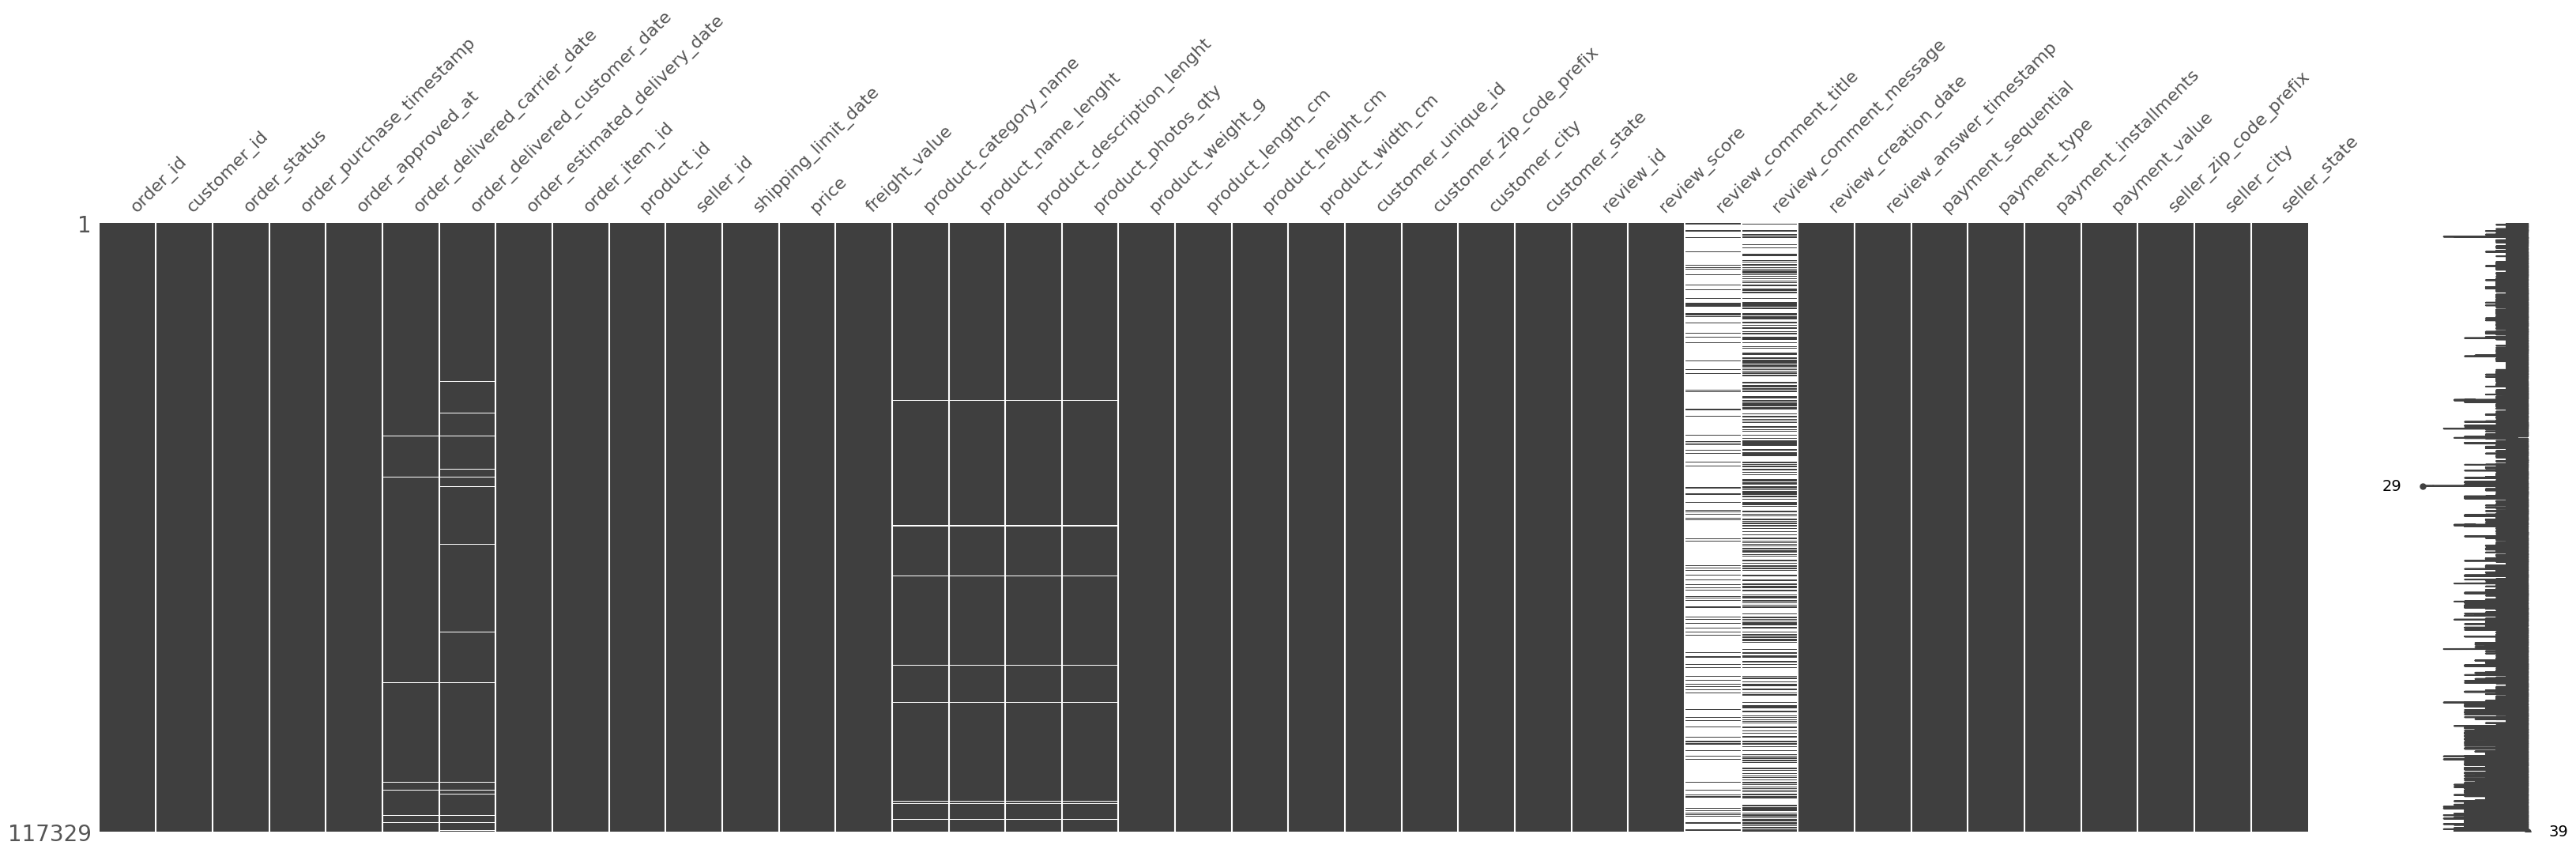

In [24]:
missingno.matrix(df, figsize=(40, 10))

In [25]:
linhas, colunas = df.shape

In [26]:
perc_null = ((df.isna().sum()/linhas)*100).round(2)
perc_null

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.05
order_delivered_customer_date     2.11
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
product_category_name             1.44
product_name_lenght               1.44
product_description_lenght        1.44
product_photos_qty                1.44
product_weight_g                  0.02
product_length_cm                 0.02
product_height_cm                 0.02
product_width_cm                  0.02
customer_unique_id                0.00
customer_zip_code_prefix          0.00
customer_city                     0.00
customer_state           

In [27]:
contagem = pd.DataFrame(columns=['Variável', 'Quantidade_Distintos'])

for colunas in df.columns:
    dados = pd.DataFrame({'Variável': [colunas], 'Quantidade_Distintos': df[colunas].value_counts().shape[0]})
    contagem = pd.concat([contagem, dados], ignore_index=True)

contagem.sort_values(by='Quantidade_Distintos')

,Variável,Quantidade_Distintos
33,payment_type,4
27,review_score,5
2,order_status,7
17,product_photos_qty,19
8,order_item_id,21
38,seller_state,23
34,payment_installments,24
25,customer_state,27
32,payment_sequential,29
15,product_name_lenght,66


In [28]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,order_id[object],1. 895ab968e7bb0d5659d16cd74cd1652. fedcd9f7ccdc8cba3a18defedd1a553. fa65dad1b0e818e3ccc5cb0e3923134. ccf804e764ed5650cd8759557269dc5. c6492b842ac190db807c15aff21a7d6. 68986e4324f6a21481df4e6e89abcf7. a3725dfe487d359b5be08cac48b64e8. 465c2e1bee4561cb39e0db8c5993aa9. 6d58638e32674bebee793a47ac4cba10. 5a3b1c29a49756e75f1ef513383c0c11. other,"63 (0.1%)38 (0.0%)29 (0.0%)26 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)22 (0.0%)117,031 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC7ElEQVR4nO3csY3DMBQFQVK4Ahg4O0C1XA3qP3URjnRdLAFrpgIGC/xET/O+7wGFY/cDeA6xkREbGbGRERsZsZERGxmxkREbGbGROeacv7sfwTMcYwyxkXBGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MMcZ4734EzzD9xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkZnnef6ttV67H8L3+1lrva7r+ux+CN/PGSUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI+PjSTIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIj8w8mmTToGD539gAAAABJRU5ErkJggg=="">",0(0.0%)
2,customer_id[object],1. 270c23a11d024a44c896d1894b261a2. 13aa59158da63ba0e93ec6ac2c07aa3. 9af2372a1e49340278e7c1ef8d749f4. 92cd3ec6e2d643d4ebd0e3d6238f695. 6ee2f17e3b6c33d6a9557f280edd296. 86cc80fef09f7f39df4b0dbce48e817. d22f25a9fadfb1abbc2e29395b12398. 63b964e79dee32a3587651701a2b8d9. 2ba91e12e5e4c9f56b82b86d9031d310. be1c4e52bb71e0c54b11a26b8e8d5911. other,"63 (0.1%)38 (0.0%)29 (0.0%)26 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)24 (0.0%)22 (0.0%)117,031 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC7ElEQVR4nO3csY3DMBQFQVK4Ahg4O0C1XA3qP3URjnRdLAFrpgIGC/xET/O+7wGFY/cDeA6xkREbGbGRERsZsZERGxmxkREbGbGROeacv7sfwTMcYwyxkXBGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MMcZ4734EzzD9xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkZnnef6ttV67H8L3+1lrva7r+ux+CN/PGSUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI+PjSTIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIj8w8mmTToGD539gAAAABJRU5ErkJggg=="">",0(0.0%)
3,order_status[object],1. delivered2. shipped3. canceled4. invoiced5. processing6. unavailable7. approved,"114,859 (97.9%)1,167 (1.0%)553 (0.5%)370 (0.3%)370 (0.3%)7 (0.0%)3 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACNklEQVR4nO3bIW4bURhG0TcjS6UDwirNWrIGL9Rr6FYMygweLXJIEnkB9R0pPgcZPnA1P/G33O/3AYX16AfwOsRGRmxkxEZGbGTERmbZ9/1927a3ox/CzzTn

In [29]:
payment_counts = df['payment_type'].value_counts().reset_index()
payment_counts.columns = ['Tipo_pagamento', 'valores']
payment_counts

,Tipo_pagamento,valores
0,credit_card,86520
1,boleto,22835
2,voucher,6282
3,debit_card,1692


In [30]:
payment_counts.Tipo_pagamento[0]

'credit_card'

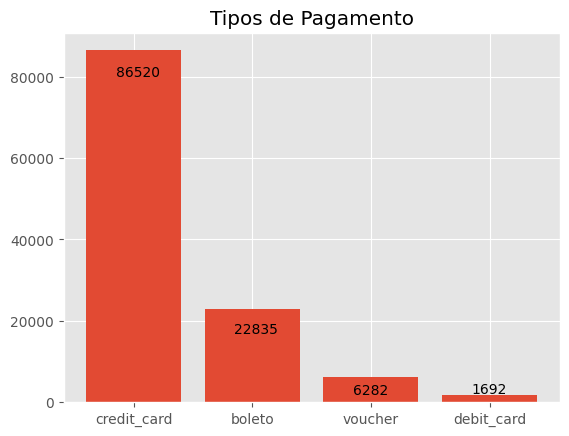

In [31]:
plt.bar(data=payment_counts, x='Tipo_pagamento', height='valores')

plt.title('Tipos de Pagamento')
_ = plt.text(-0.15, 8e4, payment_counts.valores[0])
_ = plt.text(0.85, 17e3, payment_counts.valores[1])
_ = plt.text(1.85, 2e3, payment_counts.valores[2])
_ = plt.text(2.85, 2.2e3, payment_counts.valores[3])

_ = plt.plot()

In [32]:
df_numeric = df.select_dtypes(include=[np.number])
df_categories = df.select_dtypes(include=[object])

<Axes: title={'center': 'Correlação entre Variáveis'}>

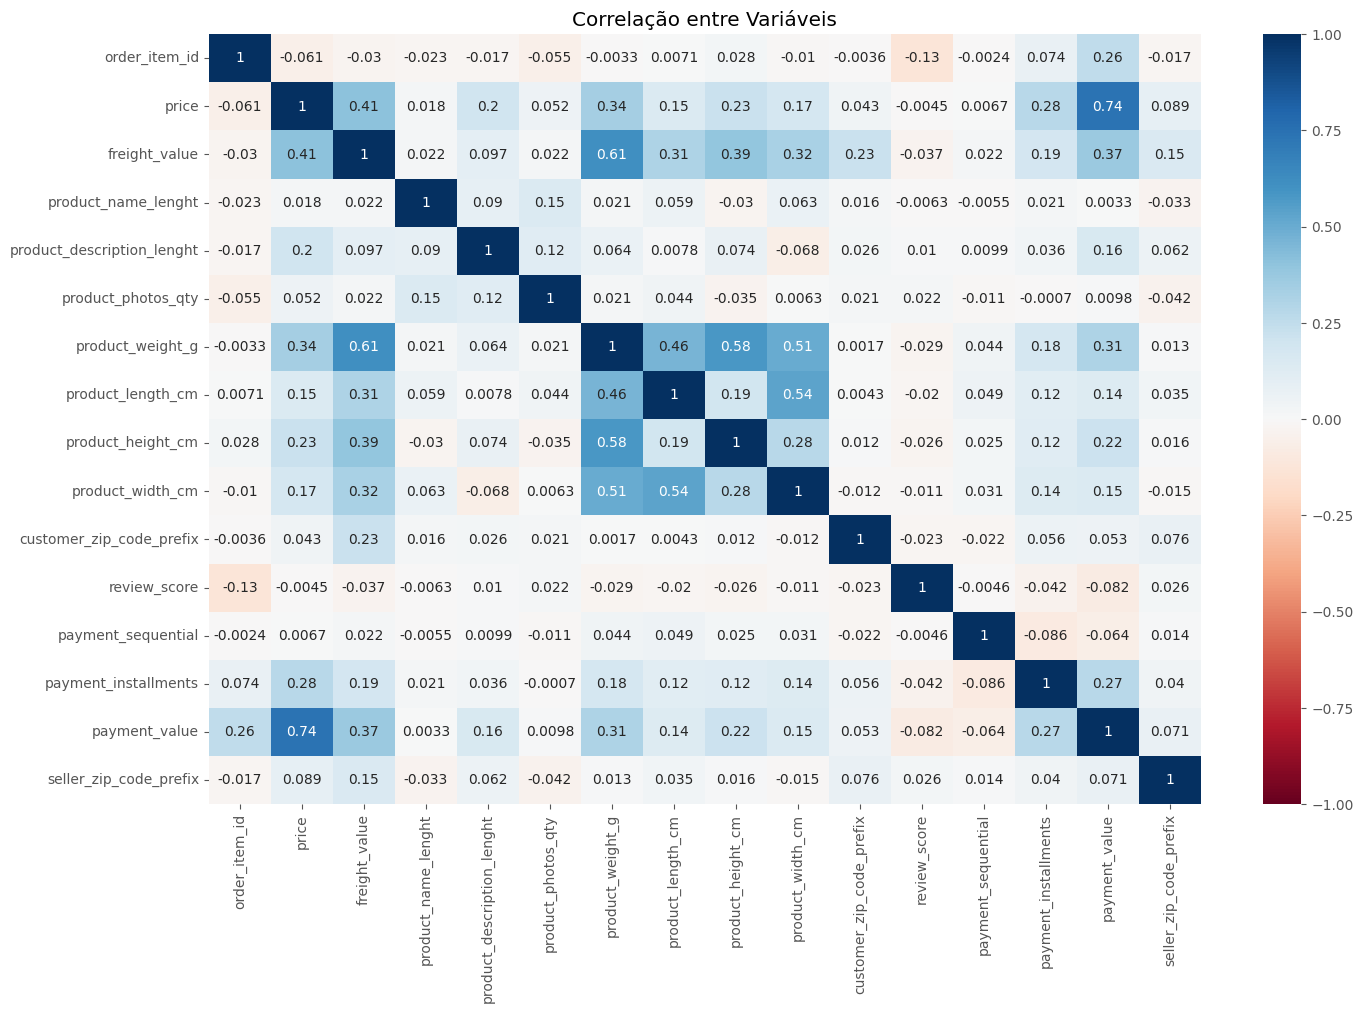

In [33]:
plt.figure(figsize=(16,10))

plt.title('Correlação entre Variáveis')

sns.heatmap(df_numeric.corr(), annot=True, vmin=-1, vmax=1, cmap='RdBu')

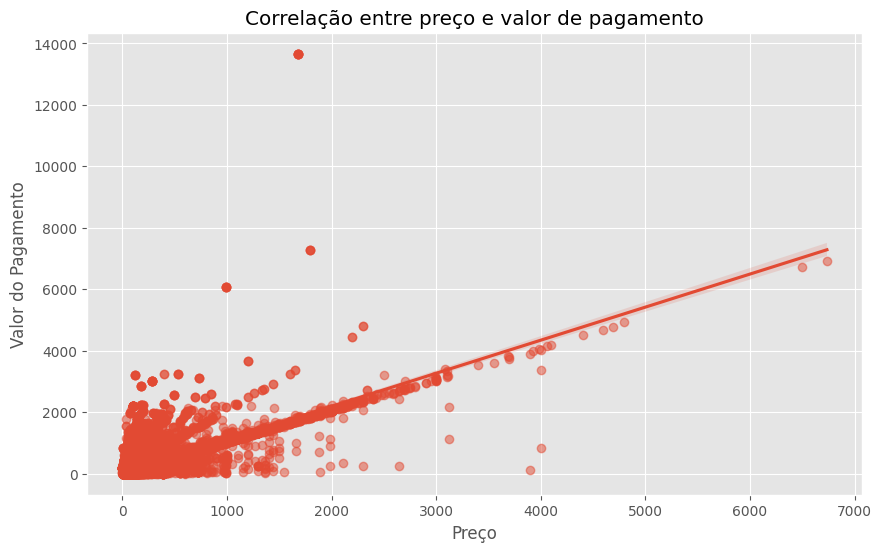

In [34]:
_ = plt.figure(figsize=(10, 6))
_ = sns.regplot(x='price', y='payment_value', data=df, scatter_kws=({'alpha':0.5}))
_ = plt.title('Correlação entre preço e valor de pagamento')
_ = plt.xlabel('Preço')
_ = plt.ylabel('Valor do Pagamento')
_ = plt.show()

In [35]:
payment_outlier = payments.query('payment_value > 13000')
payment_outlier

order_sus = order_items.query('order_id == "03caa2c082116e1d31e67e9ae3700499"')
products.query('product_id	 == "5769ef0a239114ac3a854af00df129e4"')
comment = reviews.query('order_id == "03caa2c082116e1d31e67e9ae3700499"')

comment.review_comment_message.values
orders.query('order_id == "03caa2c082116e1d31e67e9ae3700499"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
13390,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00


(array([0]), [Text(0, 0, '')])

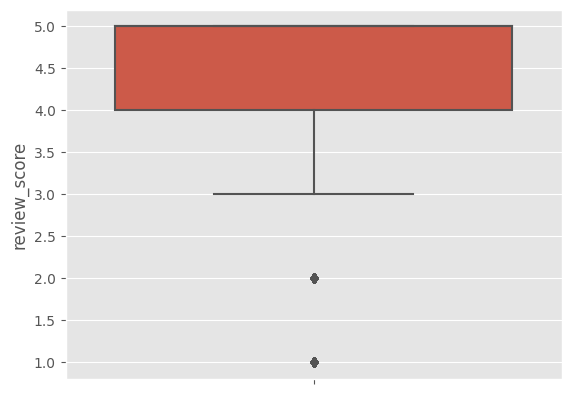

In [36]:
fig = sns.boxplot(y='review_score', data=df)
plt.xticks(rotation=90)

In [37]:
df.review_score.describe()

count    117329.000000
mean          4.031467
std           1.387927
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

<Axes: xlabel='review_score', ylabel='count'>

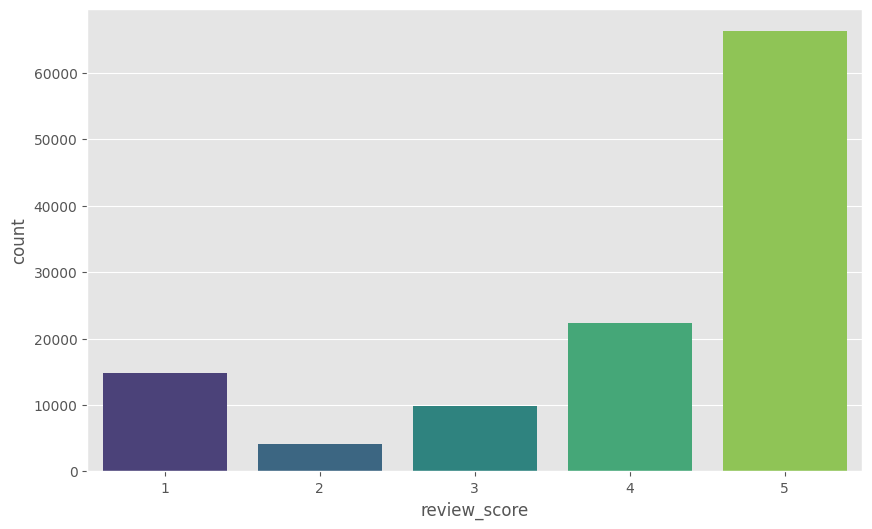

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='review_score', palette='viridis')

<Axes: ylabel='price'>

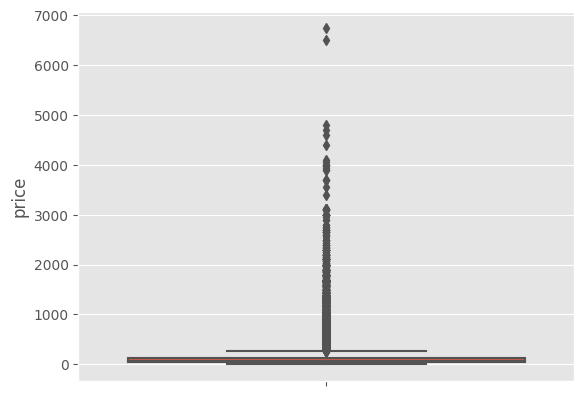

In [39]:
fig = sns.boxplot(y='price', data=df)
fig

In [40]:
df.price.describe()

count    117329.000000
mean        120.524349
std         182.944843
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [41]:
query = 'SELECT DISTINCT order_id, sum(price) FROM order_items GROUP BY order_id'
result = psql(query, globals())
result.describe()

,sum(price)
count,98666.000000
mean,137.754076
std,210.645145
min,0.850000
25%,45.900000
50%,86.900000
75%,149.900000
max,13440.000000


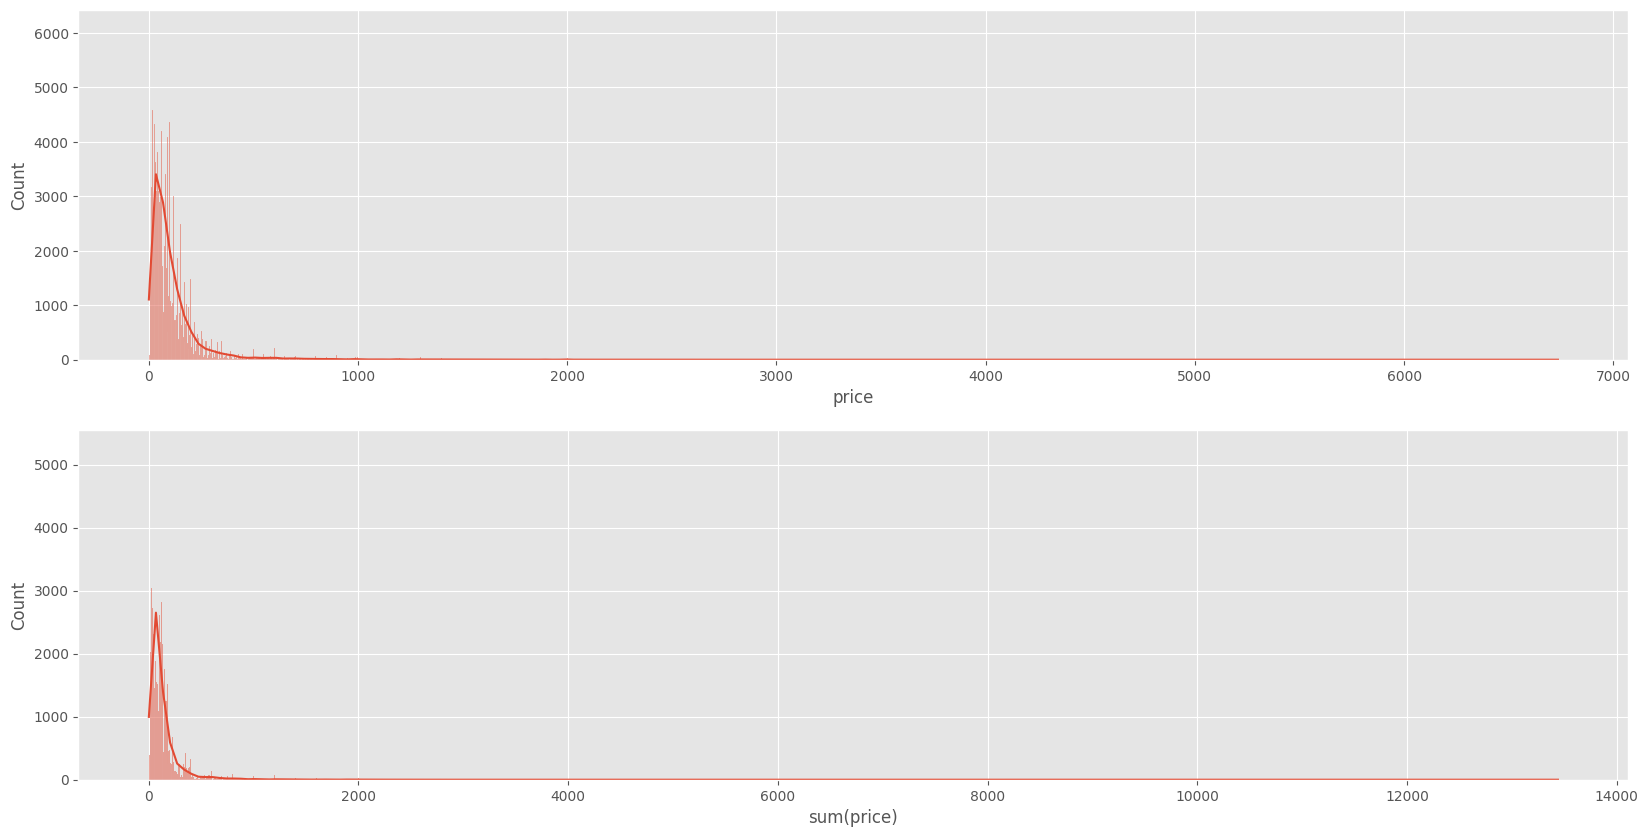

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
_ = sns.histplot(data=df, x='price', ax=axes[0], kde=True)
_ = sns.histplot(data=result, x='sum(price)', ax=axes[1], kde=True)

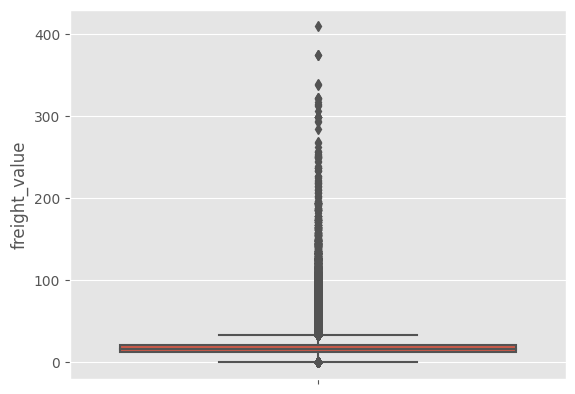

In [43]:
fig = sns.boxplot(y='freight_value', data=df)
_ = plt.show()

In [44]:
df.freight_value.describe()

count    117329.000000
mean         20.027514
std          15.828077
min           0.000000
25%          13.080000
50%          16.280000
75%          21.180000
max         409.680000
Name: freight_value, dtype: float64

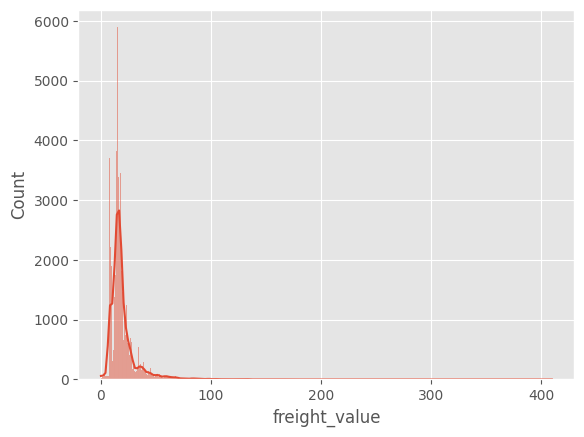

In [45]:
fig= plt.plot(figsize=(20, 10))
_ = sns.histplot(data=df, x='freight_value', kde=True)

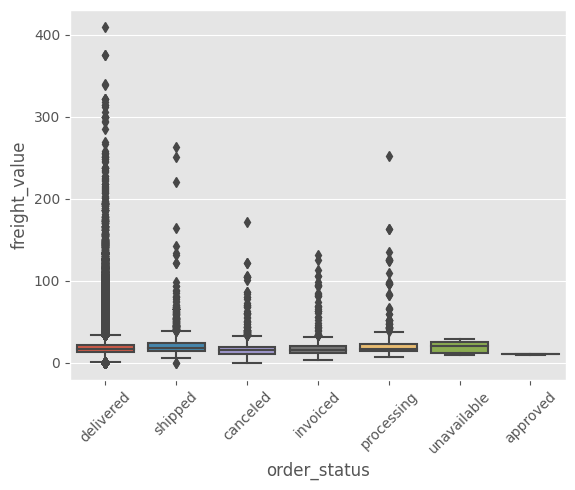

In [46]:
fig= plt.plot(figsize=(20, 10))
_ = sns.boxplot(data=df, x='order_status', y='freight_value')
_ = plt.xticks(rotation=45)

In [47]:
df['product_volume'] = df['product_height_cm'] * df['product_width_cm'] * df['product_length_cm']
df['product_volume']

0          1976.0
1          1976.0
2          1976.0
3          1976.0
4          1976.0
           ...   
117324    23520.0
117325      704.0
117326    19200.0
117327    35301.0
117328     1768.0
Name: product_volume, Length: 117329, dtype: float64

In [48]:
df['product_density'] = df['product_weight_g'] / df['product_volume']
df['product_density']

0         0.253036
1         0.253036
2         0.253036
3         0.253036
4         0.253036
            ...   
117324    0.031888
117325    0.568182
117326    0.109375
117327    0.167134
117328    0.046946
Name: product_density, Length: 117329, dtype: float64

In [49]:
to_date = df.iloc[:, 3:8]
to_date = to_date.apply(pd.to_datetime)
to_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       117329 non-null  datetime64[ns]
 1   order_approved_at              117314 non-null  datetime64[ns]
 2   order_delivered_carrier_date   116094 non-null  datetime64[ns]
 3   order_delivered_customer_date  114858 non-null  datetime64[ns]
 4   order_estimated_delivery_date  117329 non-null  datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 5.4 MB


In [50]:
df.iloc[:, 3:8] = to_date

In [51]:
df['tempo_entrega'] = (df.order_delivered_customer_date - df.order_purchase_timestamp).dt.days
df['tempo_entrega'] = df.tempo_entrega.apply(pd.to_numeric)

In [52]:
df['tempo_entrega_estimada'] = (df.order_estimated_delivery_date - df.order_purchase_timestamp).dt.days
df['tempo_entrega_estimada'] = df.tempo_entrega_estimada.apply(pd.to_numeric)

In [53]:
df['tempo_processamento_minutos'] = ((df.order_approved_at - df.order_purchase_timestamp).dt.seconds/60).round(0)
df['tempo_processamento_minutos'] = df.tempo_processamento_minutos.apply(pd.to_numeric)

In [54]:
df.tempo_processamento_minutos.describe()

count    117314.000000
mean        239.255306
std         397.942416
min           0.000000
25%          13.000000
50%          20.000000
75%         290.000000
max        1440.000000
Name: tempo_processamento_minutos, dtype: float64

In [55]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,product_volume,product_density,tempo_entrega,tempo_entrega_estimada,tempo_processamento_minutos
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,9350,maua,SP,1976.0,0.253036,8.0,15,11.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,2.00,9350,maua,SP,1976.0,0.253036,8.0,15,11.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,18.59,9350,maua,SP,1976.0,0.253036,8.0,15,11.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,credit_card,3,37.77,9350,maua,SP,1976.0,0.253036,2.0,12,96.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,credit_card,1,37.77,9350,maua,SP,1976.0,0.253036,5.0,12,18.0


In [56]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [57]:
geolocation_agregada = geolocation.groupby(by='geolocation_zip_code_prefix').agg({'geolocation_lat': 'mean', 'geolocation_lng': 'mean'}).reset_index()
geolocation_agregada.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [58]:
df=pd.merge(df, geolocation_agregada, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)
df.drop(columns='geolocation_zip_code_prefix', inplace=True)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,product_volume,product_density,tempo_entrega,tempo_entrega_estimada,tempo_processamento_minutos,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,2.00,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,18.59,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,credit_card,3,37.77,9350,maua,SP,1976.0,0.253036,2.0,12,96.0,-23.680729,-46.444238
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,credit_card,1,37.77,9350,maua,SP,1976.0,0.253036,5.0,12,18.0,-23.680729,-46.444238


In [59]:
df=pd.merge(df, geolocation_agregada, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}, inplace=True)
df.drop(columns='geolocation_zip_code_prefix', inplace=True)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,product_volume,product_density,tempo_entrega,tempo_entrega_estimada,tempo_processamento_minutos,seller_lat,seller_lng,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238,-23.576983,-46.587161
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,2.00,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238,-23.576983,-46.587161
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,18.59,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,-23.680729,-46.444238,-23.576983,-46.587161
3,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,cama_mesa_banho,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,3cd186b6013f4145b9bd406847b61f19,5,NaN,Nâo sabia da entrega aos domingos pelo correio...,2018-03-26 00:00:00,2018-03-27 02:21:27,1,credit_card,2,223.38,13405,piracicaba,SP,14440.0,0.072715,2.0,12,42.0,-22.708702,-47.664701,-23.576983,-46.587161
4,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,2,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,cama_mesa_banho,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,3cd186b6013f4145b9bd406847b61f19,5,NaN,Nâo sabia da entrega aos domingos pelo correio...,2018-03-26 00:00:00,2018-03-27 02:21:27,1,credit_card,2,223.38,13405,piracicaba,SP,14440.0,0.072715,2.0,12,42.0,-22.708702,-47.664701,-23.576983,-46.587161


In [60]:
def calc_distance(dataframe):
    seller_coord = (dataframe['seller_lat'], dataframe['seller_lng'])
    customer_coord = (dataframe['customer_lat'], dataframe['customer_lng'])
    
    return geodesic(seller_coord, customer_coord).kilometers

In [61]:
df['distancia'] = df.apply(calc_distance, axis=1)

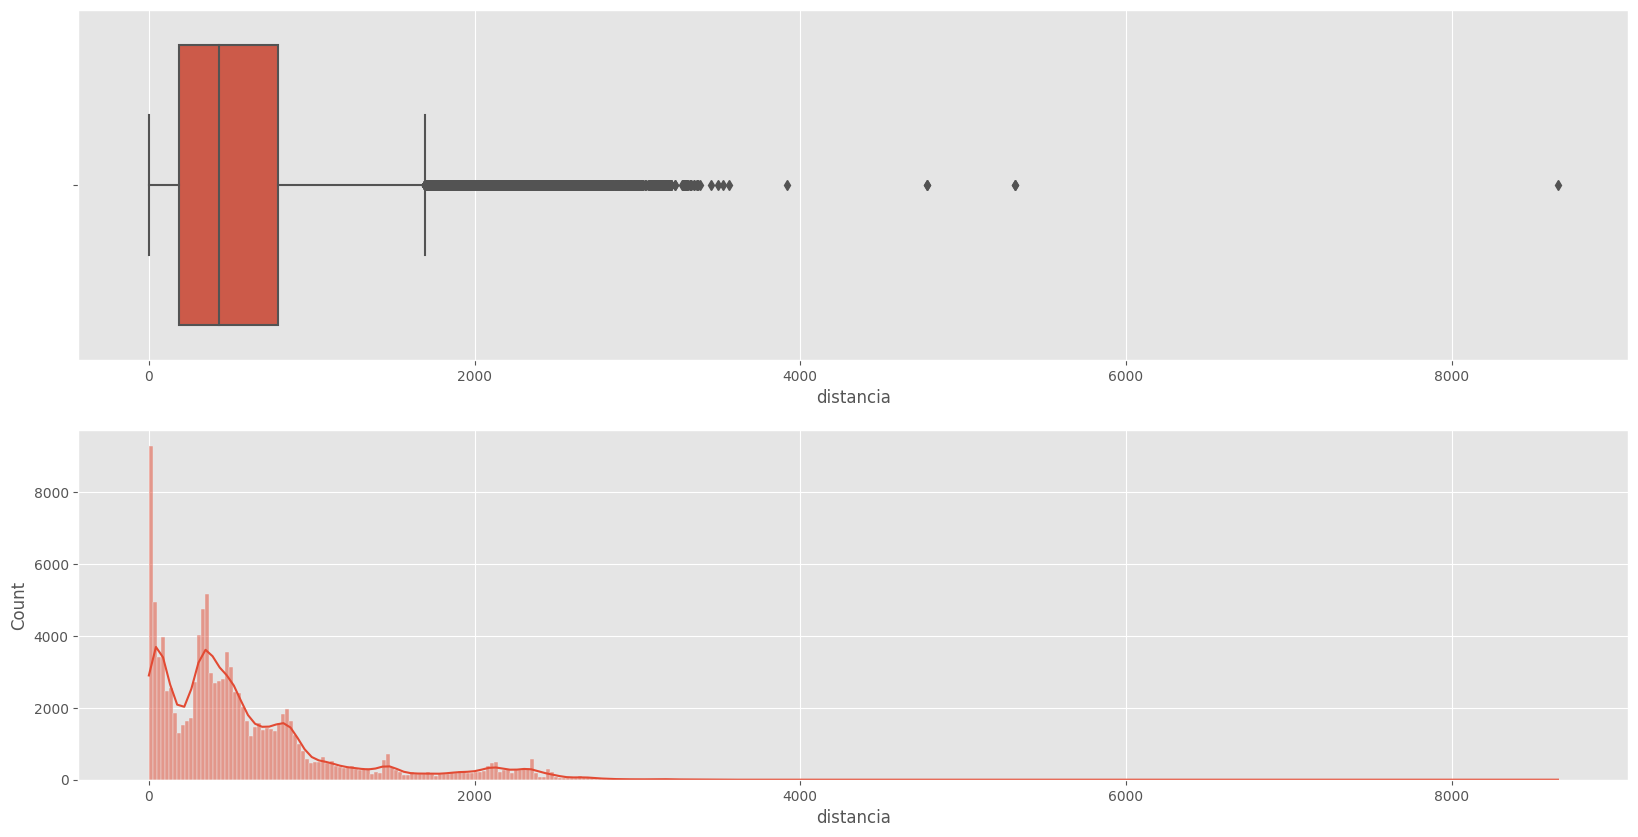

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
_ = sns.boxplot(data=df, x='distancia', ax=axes[0])
_ = sns.histplot(data=df, x='distancia', kde=True, ax=axes[1])

In [63]:
df.distancia.describe()

count    116750.000000
mean        595.388652
std         586.709521
min           0.000000
25%         186.934233
50%         431.120644
75%         790.094537
max        8652.119722
Name: distancia, dtype: float64

In [64]:
df.drop(columns=['seller_lat', 'seller_lng', 'customer_lat', 'customer_lng'], inplace=True)
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,product_volume,product_density,tempo_entrega,tempo_entrega_estimada,tempo_processamento_minutos,distancia
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,18.566632
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,3,voucher,1,2.00,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,18.566632
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,2,voucher,1,18.59,9350,maua,SP,1976.0,0.253036,8.0,15,11.0,18.566632
3,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,cama_mesa_banho,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,3cd186b6013f4145b9bd406847b61f19,5,NaN,Nâo sabia da entrega aos domingos pelo correio...,2018-03-26 00:00:00,2018-03-27 02:21:27,1,credit_card,2,223.38,13405,piracicaba,SP,14440.0,0.072715,2.0,12,42.0,146.370789
4,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,delivered,2018-03-22 17:23:21,2018-03-22 18:05:36,2018-03-23 18:03:03,2018-03-25 17:22:41,2018-04-04,2,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,2018-03-28 18:05:36,99.90,11.79,cama_mesa_banho,55.0,273.0,1.0,1050.0,38.0,10.0,38.0,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,3cd186b6013f4145b9bd406847b61f19,5,NaN,Nâo sabia da entrega aos domingos pelo correio...,2018-03-26 00:00:00,2018-03-27 02:21:27,1,credit_card,2,223.38,13405,piracicaba,SP,14440.0,0.072715,2.0,12,42.0,146.370789


In [65]:
df['mes_compra'] = df['order_purchase_timestamp'].dt.month

df['dia_semana_compra'] = df['order_purchase_timestamp'].dt.day_of_week

In [66]:
df['order_purchase_timestamp'].dt.day

0          2
1          2
2          2
3         22
4         22
          ..
116745    17
116746    16
116747     3
116748    26
116749     2
Name: order_purchase_timestamp, Length: 116750, dtype: int64

In [67]:
df['black_friday'] = df['mes_compra'] == 11
df['natal'] = (df['mes_compra'] == 12) & (df['order_purchase_timestamp'].dt.day >= 10)

In [68]:
df['black_friday'] = df['black_friday'].replace({False: 0, True: 1})
df['natal'] = df['natal'].replace({False: 0, True: 1})

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116750 entries, 0 to 116749
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       116750 non-null  object        
 1   customer_id                    116750 non-null  object        
 2   order_status                   116750 non-null  object        
 3   order_purchase_timestamp       116750 non-null  datetime64[ns]
 4   order_approved_at              116735 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115525 non-null  datetime64[ns]
 6   order_delivered_customer_date  114296 non-null  datetime64[ns]
 7   order_estimated_delivery_date  116750 non-null  datetime64[ns]
 8   order_item_id                  116750 non-null  int64         
 9   product_id                     116750 non-null  object        
 10  seller_id                      116750 non-null  object        
 11  

In [70]:
drop_cols = [
             'order_id',
             'customer_id',
             'product_id',
             'seller_id',
             'order_status',
             'order_purchase_timestamp',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date',
             'shipping_limit_date',
             'product_description_lenght',
             'product_name_lenght',
             'product_photos_qty',
             'customer_unique_id',
             'review_id',
             'review_comment_title',
             'review_comment_message',
             'review_creation_date',
             'review_answer_timestamp',
             'payment_sequential',
             'payment_type',
             'payment_installments',
             'payment_value',
             'seller_zip_code_prefix',
             'order_item_id',
             'customer_zip_code_prefix'
]

In [71]:
df.drop(columns=drop_cols, inplace=True)

In [72]:
df.duplicated().value_counts()

False    101106
True      15644
dtype: int64

In [73]:
df.drop_duplicates(inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101106 entries, 0 to 116749
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   price                        101106 non-null  float64
 1   freight_value                101106 non-null  float64
 2   product_category_name        99663 non-null   object 
 3   product_weight_g             101090 non-null  float64
 4   product_length_cm            101090 non-null  float64
 5   product_height_cm            101090 non-null  float64
 6   product_width_cm             101090 non-null  float64
 7   customer_city                101106 non-null  object 
 8   customer_state               101106 non-null  object 
 9   review_score                 101106 non-null  int64  
 10  seller_city                  101106 non-null  object 
 11  seller_state                 101106 non-null  object 
 12  product_volume               101090 non-null  float64
 13 

MODELAGEM

In [75]:
X = df.drop(columns='freight_value', axis=1)
y = df.freight_value

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [107]:
model_XGBoost = XGBRegressor(n_estimators=500, max_depth=8, learning_rate=1e-3, n_jobs=-1, random_state=0)
model_LightGBM = LGBMRegressor(n_estimators=1000, max_depth=8, num_leaves=2, learning_rate=1e-3, n_jobs=-1, verbose=-1, random_state=0)
model_CatBoost = CatBoostRegressor(n_estimators=1000, max_depth=8, learning_rate=1e-3, verbose=0, random_state=0)
model_Tree = DecisionTreeRegressor(random_state=0, max_depth=8, min_samples_split=2)

In [78]:
def encoder_importance(encoder, train, test, model):
    enc = encoder
    X_train_encoded = train
    X_test_encoded = test

    for col in X_train_encoded.select_dtypes(include=['object']).columns:

        X_train_encoded[col] = enc.fit_transform(X_train_encoded[col], y_train)
        X_test_encoded[col] = enc.transform(X_test_encoded[col])

    model.fit(X_train_encoded, y_train)

    r = permutation_importance(model, X_test_encoded, y_test, n_repeats=30,
                                random_state=0)
    
    importances = pd.DataFrame({'Feature': X_test_encoded.columns, 
                            'Importance': r.importances_mean})
    
    importances = importances.sort_values(by='Importance', ascending=False)

    return importances

In [79]:
feature_importance = encoder_importance(CatBoostEncoder(), X_train, X_test, model_XGBoost)
feature_importance

,Feature,Importance
11,product_volume,0.217941
16,distancia,0.208997
2,product_weight_g,0.172704
0,price,0.111978
9,seller_city,0.022675
7,customer_state,0.019967
10,seller_state,0.017901
3,product_length_cm,0.016262
12,product_density,0.005333
4,product_height_cm,0.004809


In [80]:
last_columns = feature_importance[feature_importance['Importance'] <= 0]
last_columns = last_columns.Feature.values.tolist()
last_columns

['review_score', 'tempo_processamento_minutos', 'tempo_entrega_estimada']

In [81]:
X_train.drop(columns=last_columns, inplace=True)
X_test.drop(columns=last_columns, inplace=True)

In [82]:
feature_importance_v2 = encoder_importance(CatBoostEncoder(), X_train, X_test, model_XGBoost)
feature_importance_v2

,Feature,Importance
10,product_volume,0.221239
13,distancia,0.210484
2,product_weight_g,0.174926
0,price,0.114600
8,seller_city,0.022451
7,customer_state,0.021788
9,seller_state,0.017848
3,product_length_cm,0.013254
11,product_density,0.006228
4,product_height_cm,0.003671


In [83]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70774 entries, 82836 to 18171
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  70774 non-null  float64
 1   product_category_name  70774 non-null  float64
 2   product_weight_g       70763 non-null  float64
 3   product_length_cm      70763 non-null  float64
 4   product_height_cm      70763 non-null  float64
 5   product_width_cm       70763 non-null  float64
 6   customer_city          70774 non-null  float64
 7   customer_state         70774 non-null  float64
 8   seller_city            70774 non-null  float64
 9   seller_state           70774 non-null  float64
 10  product_volume         70763 non-null  float64
 11  product_density        70763 non-null  float64
 12  tempo_entrega          69287 non-null  float64
 13  distancia              70774 non-null  float64
 14  mes_compra             70774 non-null  int64  
 15

In [84]:
k = 5

folds = KFold(n_splits=k, shuffle=True, random_state=0)

absolute_error = list()
squared_error = list()
r2 = list()

for k, (train_index, test_index) in enumerate(folds.split(X, y)):

    print('#-'*8 + f'Fold: {k+1}' + '#-'*8)
    
    X_train_i, y_train_i = X.iloc[train_index, :], y.iloc[train_index]
    X_test_i, y_test_i = X.iloc[test_index, :], y.iloc[test_index]

    encoder = CatBoostEncoder()
    
    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')

    cat_pipeline = Pipeline(
                                [
                                    ('encoder', encoder),
                                    ('imputer', cat_imputer)
                                ]
                            )
    
    num_pipeline = Pipeline(
                                [
                                    ('imputer', num_imputer)
                                ]
                            )
    
    cat_cols = X_train_i.select_dtypes(include=['object']).columns
    num_cols = X_train_i.select_dtypes(exclude=['object']).columns

    X_train_i[cat_cols] = cat_pipeline.fit_transform(
        X_train_i[cat_cols], y_train_i)
    
    X_train_i[num_cols] = num_pipeline.fit_transform(
        X_train_i[num_cols])
    
    X_test_i[cat_cols] = cat_pipeline.transform(
        X_test_i[cat_cols])

    X_test_i[num_cols] = num_pipeline.transform(
        X_test_i[num_cols])
    
    model_XGBoost.fit(X_train_i, y_train_i)

    y_pred = model_XGBoost.predict(X_test_i)

    r2score = r2_score(y_test_i, y_pred)
    mse = mean_squared_error(y_test_i, y_pred)
    mae = mean_absolute_error(y_test_i, y_pred)
    
    r2.append(r2score)
    squared_error.append(mse)
    absolute_error.append(mae)

    print(f'R2: {r2score:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')


#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
R2: 0.412
MSE: 149.615
MAE: 7.468
#-#-#-#-#-#-#-#-Fold: 2#-#-#-#-#-#-#-#-
R2: 0.409
MSE: 137.056
MAE: 7.209
#-#-#-#-#-#-#-#-Fold: 3#-#-#-#-#-#-#-#-
R2: 0.421
MSE: 164.051
MAE: 7.486
#-#-#-#-#-#-#-#-Fold: 4#-#-#-#-#-#-#-#-
R2: 0.411
MSE: 140.079
MAE: 7.277
#-#-#-#-#-#-#-#-Fold: 5#-#-#-#-#-#-#-#-
R2: 0.414
MSE: 149.644
MAE: 7.408


In [88]:
r2 = np.array(r2)
squared_errors = np.array(squared_error)
absolute_errors = np.array(absolute_error)

mean_r2 = np.mean(r2)
mean_mse = np.mean(squared_errors)
mean_mae = np.mean(absolute_errors)

std_r2 = np.std(r2)
std_mse = np.std(squared_errors)
std_mae = np.std(absolute_errors)

print('#-'*8 + f' Exibindo Métricas ' + '-#'*8)

print(f'Média R2: {mean_r2} +- {std_r2}')
print(f'Média MSE: {mean_mse} +- {std_mse}')
print(f'Média MAE: {mean_mae} +- {std_mae}')


#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.41362329581129204 +- 0.004114573700202864
Média MSE: 148.08899718364785 +- 9.43854437649913
Média MAE: 7.369504204754568 +- 0.10858518136031393


In [91]:
def cv(X, y, model, k):

    folds = KFold(n_splits=k, shuffle=True, random_state=0)

    absolute_error = list()
    squared_error = list()
    r2 = list()

    for k, (train_index, test_index) in enumerate(folds.split(X, y)):

        print('#-'*8 + f'Fold: {k+1}' + '#-'*8)
        
        X_train_i, y_train_i = X.iloc[train_index, :], y.iloc[train_index]
        X_test_i, y_test_i = X.iloc[test_index, :], y.iloc[test_index]

        encoder = CatBoostEncoder()
        
        cat_imputer = SimpleImputer(strategy='most_frequent')
        num_imputer = SimpleImputer(strategy='median')

        cat_pipeline = Pipeline(
                                    [
                                        ('encoder', encoder),
                                        ('imputer', cat_imputer)
                                    ]
                                )
        
        num_pipeline = Pipeline(
                                    [
                                        ('imputer', num_imputer)
                                    ]
                                )
        
        cat_cols = X_train_i.select_dtypes(include=['object']).columns
        num_cols = X_train_i.select_dtypes(exclude=['object']).columns

        X_train_i[cat_cols] = cat_pipeline.fit_transform(
            X_train_i[cat_cols], y_train_i)
        
        X_train_i[num_cols] = num_pipeline.fit_transform(
            X_train_i[num_cols])
        
        X_test_i[cat_cols] = cat_pipeline.transform(
            X_test_i[cat_cols])

        X_test_i[num_cols] = num_pipeline.transform(
            X_test_i[num_cols])
        
        model.fit(X_train_i, y_train_i)

        y_pred = model.predict(X_test_i)

        r2score = r2_score(y_test_i, y_pred)
        mse = mean_squared_error(y_test_i, y_pred)
        mae = mean_absolute_error(y_test_i, y_pred)
        
        r2.append(r2score)
        squared_error.append(mse)
        absolute_error.append(mae)

        print(f'R2: {r2score:.3f}')
        print(f'MSE: {mse:.3f}')
        print(f'MAE: {mae:.3f}')

    r2 = np.array(r2)
    squared_errors = np.array(squared_error)
    absolute_errors = np.array(absolute_error)

    mean_r2 = np.mean(r2)
    mean_mse = np.mean(squared_errors)
    mean_mae = np.mean(absolute_errors)

    std_r2 = np.std(r2)
    std_mse = np.std(squared_errors)
    std_mae = np.std(absolute_errors)

    print('#-'*8 + f' Exibindo Métricas ' + '-#'*8)

    print(f'Média R2: {mean_r2} +- {std_r2}')
    print(f'Média MSE: {mean_mse} +- {std_mse}')
    print(f'Média MAE: {mean_mae} +- {std_mae}')


In [92]:
# XGBoost

model1 = cv(X, y, model_XGBoost, k=5)
model1

#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
R2: 0.412
MSE: 149.615
MAE: 7.468
#-#-#-#-#-#-#-#-Fold: 2#-#-#-#-#-#-#-#-
R2: 0.409
MSE: 137.056
MAE: 7.209
#-#-#-#-#-#-#-#-Fold: 3#-#-#-#-#-#-#-#-
R2: 0.421
MSE: 164.051
MAE: 7.486
#-#-#-#-#-#-#-#-Fold: 4#-#-#-#-#-#-#-#-
R2: 0.411
MSE: 140.079
MAE: 7.277
#-#-#-#-#-#-#-#-Fold: 5#-#-#-#-#-#-#-#-
R2: 0.414
MSE: 149.644
MAE: 7.408
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.41362329581129204 +- 0.004114573700202864
Média MSE: 148.08899718364785 +- 9.43854437649913
Média MAE: 7.369504204754568 +- 0.10858518136031393


In [95]:
# LightGBM

model2 = cv(X, y, model_LightGBM, k=5)
model2

#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
R2: 0.274
MSE: 184.868
MAE: 7.472
#-#-#-#-#-#-#-#-Fold: 2#-#-#-#-#-#-#-#-
R2: 0.271
MSE: 169.085
MAE: 7.337
#-#-#-#-#-#-#-#-Fold: 3#-#-#-#-#-#-#-#-
R2: 0.257
MSE: 210.778
MAE: 7.462
#-#-#-#-#-#-#-#-Fold: 4#-#-#-#-#-#-#-#-
R2: 0.275
MSE: 172.441
MAE: 7.318
#-#-#-#-#-#-#-#-Fold: 5#-#-#-#-#-#-#-#-
R2: 0.274
MSE: 185.135
MAE: 7.383
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.27035155963275226 +- 0.006995032576668219
Média MSE: 184.4616351421411 +- 14.656906364245541
Média MAE: 7.394348116621328 +- 0.06322677202841746


In [98]:
# CatBoost

model3 = cv(X, y, model_CatBoost, k=5)
model3

#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2#-#-#-#-#-#-#-#-
R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3#-#-#-#-#-#-#-#-
R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4#-#-#-#-#-#-#-#-
R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5#-#-#-#-#-#-#-#-
R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116


In [99]:
# DecisionTreeRegressor

model4 = cv(X, y, model_Tree, k=5)
model4

#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
R2: 0.638
MSE: 92.095
MAE: 4.708
#-#-#-#-#-#-#-#-Fold: 2#-#-#-#-#-#-#-#-
R2: 0.588
MSE: 95.581
MAE: 4.797
#-#-#-#-#-#-#-#-Fold: 3#-#-#-#-#-#-#-#-
R2: 0.630
MSE: 104.945
MAE: 4.901
#-#-#-#-#-#-#-#-Fold: 4#-#-#-#-#-#-#-#-
R2: 0.621
MSE: 90.317
MAE: 4.779
#-#-#-#-#-#-#-#-Fold: 5#-#-#-#-#-#-#-#-
R2: 0.588
MSE: 105.150
MAE: 4.808
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.6129369206955202 +- 0.021103461064835852
Média MSE: 97.61782114328076 +- 6.298775233523298
Média MAE: 4.798709392586803 +- 0.06170334488444619


In [113]:
def tunning(trial, k=5):
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    num_leaves=trial.suggest_float('num_leaves', 1, 10)

    folds = KFold(n_splits=k, shuffle=True, random_state=0)

    absolute_error = list()
    squared_error = list()
    r2 = list()

    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
        
        print("#-"*8 + f"Fold: {k+1}" + "-#"*8 + "\n")
        
        X_train_i, y_train_i = X.iloc[train_index, :], y.iloc[train_index]
        X_test_i, y_test_i = X.iloc[test_index, :], y.iloc[test_index]

        encoder = CatBoostEncoder()
        
        cat_imputer = SimpleImputer(strategy='most_frequent')
        num_imputer = SimpleImputer(strategy='median')

        cat_pipeline = Pipeline(
                                    [
                                        ('encoder', encoder),
                                        ('imputer', cat_imputer)
                                    ]
                                )
        
        num_pipeline = Pipeline(
                                    [
                                        ('imputer', num_imputer)
                                    ]
                                )
        
        cat_cols = X_train_i.select_dtypes(include=['object']).columns
        num_cols = X_train_i.select_dtypes(exclude=['object']).columns

        X_train_i[cat_cols] = cat_pipeline.fit_transform(
            X_train_i[cat_cols], y_train_i)
        
        X_train_i[num_cols] = num_pipeline.fit_transform(
            X_train_i[num_cols])
        
        X_test_i[cat_cols] = cat_pipeline.transform(
            X_test_i[cat_cols])

        X_test_i[num_cols] = num_pipeline.transform(
            X_test_i[num_cols])
        
        model_CatBoost.fit(X_train_i, y_train_i)

        y_pred = model_CatBoost.predict(X_test_i)

        r2score = r2_score(y_test_i, y_pred)
        mse = mean_squared_error(y_test_i, y_pred)
        mae = mean_absolute_error(y_test_i, y_pred)
        
        r2.append(r2score)
        squared_error.append(mse)
        absolute_error.append(mae)
        
        print(f'R2: {r2score:.3f}')
        print(f'MSE: {mse:.3f}')
        print(f'MAE: {mae:.3f}')

    r2 = np.array(r2)
    squared_errors = np.array(squared_error)
    absolute_errors = np.array(absolute_error)

    mean_r2 = np.mean(r2)
    mean_mse = np.mean(squared_errors)
    mean_mae = np.mean(absolute_errors)

    std_r2 = np.std(r2)
    std_mse = np.std(squared_errors)
    std_mae = np.std(absolute_errors)

    print('#-'*8 + f' Exibindo Métricas ' + '-#'*8)

    print(f'Média R2: {mean_r2} +- {std_r2}')
    print(f'Média MSE: {mean_mse} +- {std_mse}')
    print(f'Média MAE: {mean_mae} +- {std_mae}')

    return mean_mse

study = opt.create_study(direction='minimize')
study.optimize(tunning, n_trials = 20)

[I 2024-02-08 13:19:03,892] A new study created in memory with name: no-name-862c3cd0-b3e2-486b-9c6e-d7d14d344ac7


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:21:18,075] Trial 0 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.001149990112970716, 'max_depth': 10, 'subsample': 1.0, 'colsample_bytree': 0.9, 'num_leaves': 7.148239488372511}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:23:33,024] Trial 1 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0959452079326465, 'max_depth': 6, 'subsample': 0.5, 'colsample_bytree': 1.0, 'num_leaves': 8.400355474663025}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:25:44,627] Trial 2 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0054131307392393194, 'max_depth': 1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'num_leaves': 5.405357519621523}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:27:37,827] Trial 3 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0020152917557067314, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 'num_leaves': 9.026276494487094}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:29:51,003] Trial 4 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.009930035967437082, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.5, 'num_leaves': 8.484518521608823}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:32:22,380] Trial 5 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.005886730940873092, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.6, 'num_leaves': 9.601732838556387}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:34:18,320] Trial 6 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0017654768680952636, 'max_depth': 10, 'subsample': 1.0, 'colsample_bytree': 0.6, 'num_leaves': 5.133746856132976}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:36:28,228] Trial 7 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.004458597024207497, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.9, 'num_leaves': 6.937631567855094}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:38:32,041] Trial 8 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.07092071967981695, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'num_leaves': 2.8650403703939875}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:40:30,534] Trial 9 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.005942520580387502, 'max_depth': 1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'num_leaves': 3.3320355422182564}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:42:24,738] Trial 10 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.029211841917544175, 'max_depth': 7, 'subsample': 1.0, 'colsample_bytree': 1.0, 'num_leaves': 1.220317534458502}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:44:40,964] Trial 11 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.08876367741197429, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 1.0, 'num_leaves': 7.41315312334901}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:46:42,731] Trial 12 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0316374632832731, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9, 'num_leaves': 7.089250605873491}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:48:51,366] Trial 13 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.024194078855386016, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'num_leaves': 8.012211198144492}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:50:59,840] Trial 14 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.001109419708763091, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.8, 'num_leaves': 6.4390346385088355}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:52:58,940] Trial 15 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.015279699908876607, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.9, 'num_leaves': 9.634430146825174}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:54:59,174] Trial 16 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.04582256902350423, 'max_depth': 8, 'subsample': 0.6, 'colsample_bytree': 1.0, 'num_leaves': 6.105713803067367}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:57:05,743] Trial 17 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.0029769753913852213, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.8, 'num_leaves': 4.414234188963065}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 13:59:24,170] Trial 18 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.014943365437693604, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'num_leaves': 8.078494322695999}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116
#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#

R2: 0.556
MSE: 113.015
MAE: 5.658
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#

R2: 0.548
MSE: 104.836
MAE: 5.562
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#

R2: 0.546
MSE: 128.744
MAE: 5.631
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#

R2: 0.553
MSE: 106.272
MAE: 5.577
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#



[I 2024-02-08 14:01:31,788] Trial 19 finished with value: 112.96908710950215 and parameters: {'learning_rate': 0.010803097050004068, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'num_leaves': 8.76898129838197}. Best is trial 0 with value: 112.96908710950215.


R2: 0.561
MSE: 111.978
MAE: 5.562
#-#-#-#-#-#-#-#- Exibindo Métricas -#-#-#-#-#-#-#-#
Média R2: 0.5529802816380556 +- 0.00544210126395241
Média MSE: 112.96908710950215 +- 8.495101367026598
Média MAE: 5.598015560262171 +- 0.03914725681288116


In [132]:
params = study.best_params
model_CatBoost = CatBoostRegressor(n_estimators= 1000, random_state=0, learning_rate=0.010803097050004068, max_depth= 3, subsample=0.8)
cv(X, y, model_CatBoost, k=5)

#-#-#-#-#-#-#-#-Fold: 1#-#-#-#-#-#-#-#-
0:	learn: 15.8081899	total: 18.4ms	remaining: 18.4s
1:	learn: 15.7354869	total: 58.5ms	remaining: 29.2s
2:	learn: 15.6638354	total: 110ms	remaining: 36.4s
3:	learn: 15.5933263	total: 142ms	remaining: 35.3s
4:	learn: 15.5239523	total: 177ms	remaining: 35.1s
5:	learn: 15.4561947	total: 196ms	remaining: 32.6s
6:	learn: 15.3885913	total: 248ms	remaining: 35.2s
7:	learn: 15.3227981	total: 263ms	remaining: 32.6s
8:	learn: 15.2569420	total: 319ms	remaining: 35.1s
9:	learn: 15.1920105	total: 344ms	remaining: 34.1s
10:	learn: 15.1275909	total: 380ms	remaining: 34.2s
11:	learn: 15.0644086	total: 403ms	remaining: 33.1s
12:	learn: 15.0014753	total: 431ms	remaining: 32.7s
13:	learn: 14.9394044	total: 461ms	remaining: 32.5s
14:	learn: 14.8782518	total: 476ms	remaining: 31.3s
15:	learn: 14.8176101	total: 494ms	remaining: 30.4s
16:	learn: 14.7579677	total: 512ms	remaining: 29.6s
17:	learn: 14.6976660	total: 519ms	remaining: 28.3s
18:	learn: 14.6397483	total: 528